In [27]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [28]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # self.fc1 = nn.Linear(64*64, 192)
        self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.fc2 = nn.Linear(18*64*64, 192)
        self.fc3 = nn.Linear(192, 192)
        self.fc4 = nn.Linear(192, 192)
        self.fc5 = nn.Linear(192, 192)
        self.fc6 = nn.Linear(192, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 18*64*64)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        
        return F.softmax(x, dim=1)

In [29]:
X = np.load("datasets/sign-language/X.npy")
Y = np.load("datasets/sign-language/Y.npy")

In [30]:
import random
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
indices = list(range(2062))
random.shuffle(indices)
train_indices = indices[:int(0.8 * 2062)]
test_indices = indices[int(0.8 * 2062):]

X_train = [X[i] for i in train_indices]
Y_train = [int(torch.argmax(torch.tensor(Y[i]))) for i in train_indices]
X_test = [X[i] for i in test_indices]
Y_test = [int(torch.argmax(torch.tensor(Y[i]))) for i in test_indices]

In [31]:
X_train = torch.tensor(X_train).float().to(device)
Y_train = torch.tensor(Y_train).to(device)
X_test = torch.tensor(X_test).float().to(device)
Y_test = torch.tensor(Y_test).to(device)

In [32]:
net = Net().cuda()

In [33]:
output = net(X_train[0].view(1, 1, 64, 64))
output

tensor([[0.1053, 0.1053, 0.0979, 0.0979, 0.0946, 0.0974, 0.0973, 0.1035, 0.0974,
         0.1035]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [34]:
import torch.optim as optim
optimizer = optim.Adam([net.conv1.weight, net.fc2.weight, net.fc3.weight, net.fc4.weight, net.fc5.weight, net.fc6.weight], lr=0.001)
X_train = X_train
Y_train = Y_train

error_in = []
error_out_approx = []
for i in range(500):
    net.zero_grad()
    output = net(X_train.view(len(train_indices), 1, 64, 64))
    loss = F.cross_entropy(output, Y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    error_in.append(float(loss))
    output_test = net(X_test.view(len(test_indices), 1, 64, 64))
    loss_test = F.cross_entropy(output_test, Y_test)
    error_out_approx.append(float(loss_test))

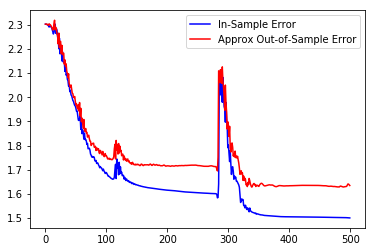

In [41]:
fig, ax = plt.subplots()
ax.plot(error_in, "b-", label="In-Sample Error")
ax.plot(error_out_approx, "r-", label="Approx Out-of-Sample Error")
leg = ax.legend()

In [42]:
output_test = net(X_test.view(len(test_indices), 1, 64, 64))

In [43]:
total = 0
correct = 0
for i, out_t in enumerate(output_test):
    if int(torch.argmax(out_t)) - int(Y_test[i]) == 0:
        correct = correct + 1
    total = total + 1

print(correct/total)

0.8305084745762712
